In [1]:
import cupy as cp
import matplotlib.pyplot as plt
from functions import R,RT,mshow_complex,mshow
from phantom import *

import cupyx.scipy.ndimage as ndimage

# load object, the object should be complex64

[0.         0.06981317 0.13962634 0.20943952 0.27925268 0.34906584
 0.41887903 0.4886922  0.55850536 0.62831855 0.6981317  0.7679449
 0.83775806 0.9075712  0.9773844  1.0471976  1.1170107  1.1868238
 1.2566371  1.3264502  1.3962634  1.4660766  1.5358897  1.6057029
 1.6755161  1.7453293  1.8151424  1.8849556  1.9547688  2.024582
 2.0943952  2.1642082  2.2340214  2.3038347  2.3736477  2.443461
 2.5132742  2.5830872  2.6529005  2.7227137  2.7925267  2.86234
 2.9321532  3.0019662  3.0717795  3.1939526  3.2637658  3.3335788
 3.403392   3.4732053  3.5430183  3.6128316  3.6826446  3.7524579
 3.822271   3.8920841  3.9618974  4.0317106  4.101524   4.171337
 4.24115    4.310963   4.3807764  4.4505897  4.520403   4.590216
 4.660029   4.729842   4.7996554  4.8694687  4.939282   5.0090947
 5.078908   5.148721   5.2185345  5.2883477  5.358161   5.4279737
 5.497787   5.5676003  5.6374135  5.7072268  5.77704    5.846853
 5.916666   5.9864793  6.0562925  6.126106   6.195919   6.265732
 0.03490658 0.104

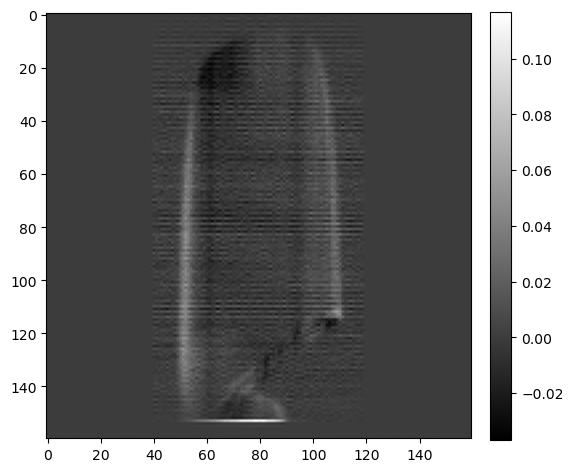

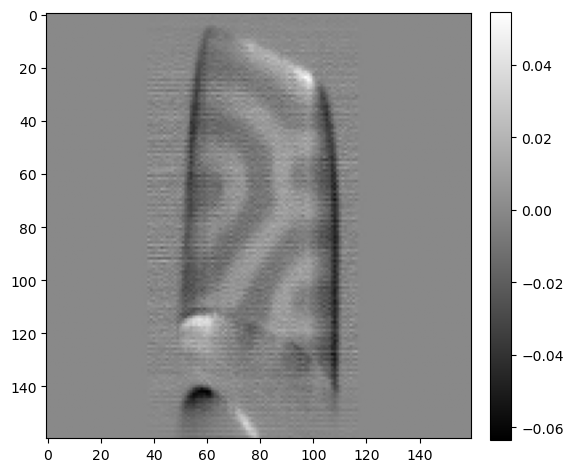

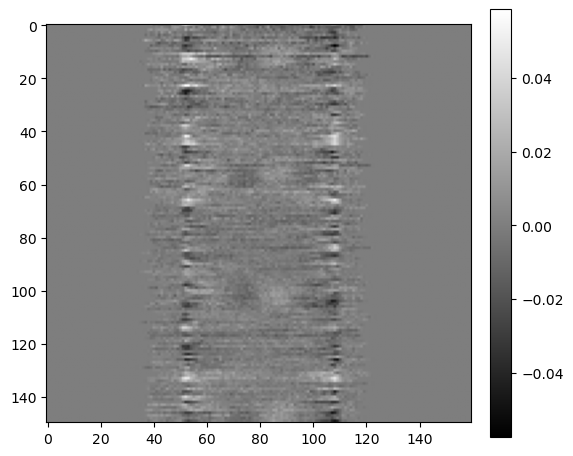

(160, 160, 160, 2)


In [2]:
# scale = 1
# shape = (scale*64, scale*64)
# centers = np.array([
#     (scale*32, scale*32),  # Center of first circle
#     (scale*24, scale*36),  # Center of second circle
#     (scale*42, scale*24),  # Center of third circle
# ])
# radii = np.array([
#     scale*24,  # Radius of first circle
#     scale*10,  # Radius of second circle
#     scale*5,   # Radius of third circle
# ])
# # domains = np.array([
# #     [1.0, 0.0],   # Direction of first circle
# #     [0.0, -1.0],   # Direction of second circle
# #     [-1.0, 1.0],   # Direction of third circle
# # ])

# sphi = np.pi/6+np.pi/2
# domains = np.array([
#     [np.cos(sphi),np.sin(sphi)],   # Direction of first circle
#     [-np.cos(sphi),-np.sin(sphi)],   # Direction of first circle
#     [-np.cos(sphi),-np.sin(sphi)],   # Direction of first circle
# ])

 
# # Create the phantom
# field, mask = create_vector_field_phantom(
#     shape, centers, radii, domains, transition_width=scale*1.0)

# w=cp.tile(field,(1,1,1,1)).astype('float32')
# mshow_complex(w[w.shape[0]//2,:,:,0]+1j*w[w.shape[0]//2,:,:,1])
# # plt.quiver(x[0,:,:,0].get(),x[0,:,:,1].get())
# plt.show()


# ## tomography pars
# theta = cp.linspace(0,cp.pi,60,endpoint=True).astype('float32')
# rotation_axis = w.shape[1]/2


## tomography pars
theta = (cp.load('tovictor/ang1.npy').astype('float32'))#cp.linspace(0,cp.pi,60,endpoint=True).astype('float32')
data = (cp.load('tovictor/prj1diff.npy').astype('float32'))[:,:160,:160].swapaxes(0,1)
# data-=cp.mean(data[data.shape[0]//2,:,:16])
print(theta)
mshow(data[:,0])
mshow(data[:,-1])
mshow(data[data.shape[0]//2])
rotation_axis = 80#w.shape[1]/2
w = cp.zeros([data.shape[0],data.shape[0],data.shape[2],2],dtype='float32')
print(w.shape)

# Make operators

In [3]:

def F1(x):
    xc = x[:,:,:,0]+1j*x[:,:,:,1]
    Rx =  R(xc,theta,rotation_axis)
    wc = -cp.cos(theta)[:,cp.newaxis]
    ws = -cp.sin(theta)[:,cp.newaxis]
    Fx = Rx.real*ws+Rx.imag*wc
    return Fx
   
def F1adj(Fx):
    wc = -cp.cos(theta)[:,cp.newaxis]
    ws = -cp.sin(theta)[:,cp.newaxis]
    Rx = Fx*ws+1j*Fx*wc
    xc = RT(Rx,theta,rotation_axis)
    x = cp.zeros([*xc.shape,2],dtype='float32')
    x[...,0] = xc.real
    x[...,1] = xc.imag
    return x

def F2(x):
    w,phi = x
    ax=w[...,0]*cp.cos(phi)+w[...,1]*cp.sin(phi)
    return ax

def dF2(x,dx):
    w,phi = x
    dw1,dphi1 = dx
    t1 = cp.cos(phi)*dw1[...,0]
    t2 = cp.sin(phi)*dw1[...,1]
    t3 = (-cp.sin(phi)*w[...,0]+cp.cos(phi)*w[...,1])*dphi1
    return t1+t2+t3

def d2F2(x,dx,dy):
    w,phi = x
    dw1,dphi1 = dx
    dw2,dphi2 = dy
    t1 = -cp.sin(phi)*(dw1[...,0]*dphi2+dw2[...,0]*dphi1)
    t2 = cp.cos(phi)*(dw1[...,1]*dphi2+dw2[...,1]*dphi1)
    t3 = -(cp.cos(phi)*w[...,0]+cp.sin(phi)*w[...,1])*dphi1*dphi2
    return t1+t2+t3
    
def dF2adj(x,ax):
    [w,phi] = x
    gw = cp.zeros([*ax.shape,2],dtype='float32')
    gw[...,0] = cp.cos(phi)*ax
    gw[...,1] = cp.sin(phi)*ax
    gphi = (-cp.sin(phi)*w[...,0]+cp.cos(phi)*w[...,1])*ax
    gphi = cp.sum(gphi)
    
    return [gw,gphi]

# Check approx

0.0 0.0
40.10922544758932 51.58506097262142
80.21845089517863 103.17012194524284
120.32767634276797 154.7551829178643
160.43690179035727 206.34024389048568
200.5461272379466 257.9253048631071
240.65535268553595 309.5103658357286
280.7645781331252 361.09542680835
320.87380358071454 412.68048778097136
360.98302902830386 464.26554875359284
401.0922544758932 515.8506097262142
441.2014799234825 567.4356706988357
481.3107053710719 619.0207316714572
521.4199308186612 670.6057926440786
561.5291562662504 722.1908536167
601.6383817138397 773.7759145893214
641.7476071614291 825.3609755619427
681.8568326090185 876.9460365345643
721.9660580566077 928.5310975071857
762.075283504197 980.1161584798072


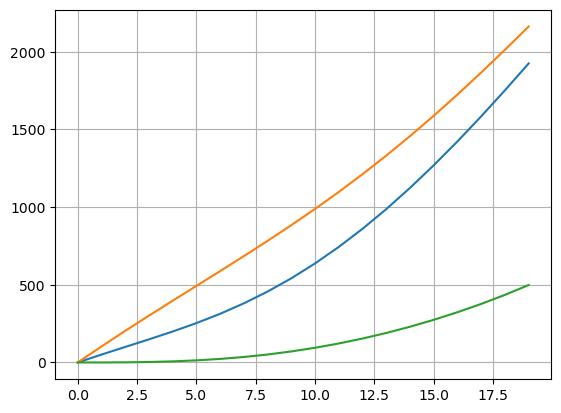

In [4]:
t = cp.random.random(w.shape).astype('float32')
dt0 = cp.random.random(w.shape).astype('float32')/10
phi0 = cp.random.random(1).astype('float32')
dphi0 = cp.random.random(1).astype('float32')/3

l = cp.linspace(0,5,20)
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dt = l[k]*dt0
    dphi = l[k]*dphi0
    a = F2([t+dt,phi0+dphi])
    print(cp.linalg.norm(dF2([t,phi0],[dt,0*dphi])),cp.linalg.norm(dF2([t,phi0],[0*dt,dphi])))
    err1[k] = cp.linalg.norm(F2([t,phi0])-a)
    err2[k] = cp.linalg.norm(F2([t,phi0])-dF2([t,phi0],[dt,dphi])-a)    
    err3[k] = cp.linalg.norm(F2([t,phi0])+dF2([t,phi0],[dt,dphi])+0.5*d2F2([t,phi0],[dt,dphi],[dt,dphi])-a)
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.grid()
plt.show()

# debug plot

In [5]:
def plot_debug(vars, etas, top, bottom, alpha, d, lam):
    """Checking second order approximation"""
    w, phi = vars['w'],vars['phi']
    weta, phieta = etas['w'],etas['phi']
    npp = 9
    errt = cp.zeros(npp * 2)
    errt2 = cp.zeros(npp * 2)
    for k in range(0, npp * 2):
        wt = w + (alpha * k / (npp - 1)) * weta
        phit = phi + (alpha * k / (npp - 1)) * phieta
        errt[k] = cp.linalg.norm(F1(wt)-d)**2+lam*cp.linalg.norm(F2([wt,phit]))**2
        
    t = alpha * (cp.arange(2 * npp)) / (npp - 1)
    errt2 = cp.linalg.norm(F1(w)-d)**2+lam*cp.linalg.norm(F2([w,phi]))**2
    errt2 = errt2 - top * t + 0.5 * bottom * t**2
    plt.plot(
        (alpha * cp.arange(2 * npp)).get() / (npp - 1),
        errt.get(),
        ".",
        label="real",
    )
    plt.plot(
        (alpha * cp.arange(2 * npp)).get() / (npp - 1),
        errt2.get(),
        ".",
        label="approx",
    )
    plt.legend()
    plt.grid()
    plt.show()

# BH functions

In [6]:

def gradient(vars,lam,d):
    w,phi = vars['w'],vars['phi']

    # first part
    gw = 2*F1adj(F1(w)-d) 
    
    # second part
    gw0,gphi = dF2adj([w,phi],2*lam*F2([w,phi]))    
    
    # result
    grads = {}
    grads['w'] = gw + gw0
    grads['phi'] = gphi
    return grads

def hessian_F1(vars,grads,etas):
    dw1 = grads['w']
    dw2 = etas['w']
    
    F1y = F1(dw1)
    F1z = F1(dw2)     
    t1 = 2*cp.real(cp.sum(F1y*cp.conj(F1z)))  
    return t1

def hessian_F2(vars,grads,etas,lam):
    w,phi = vars['w'],vars['phi']
    dw1,dphi1 = grads['w'],grads['phi']
    dw2,dphi2 = etas['w'],etas['phi']
    
    dF21 = dF2([w,phi],[dw1,dphi1])
    dF22 = dF2([w,phi],[dw2,dphi2])
    t1 = 2*cp.real(cp.sum(dF21*cp.conj(dF22)))
    
    d2F = d2F2([w,phi],[dw1,dphi1],[dw2,dphi2])
    t2 = 2*cp.real(cp.sum(F2([w,phi])*cp.conj(d2F)))
    return lam*(t1+t2)

def hessian(vars,grads,etas,lam):
    return hessian_F1(vars,grads,etas)+hessian_F2(vars,grads,etas,lam)

def calc_err(vars,lam,d):
    w,phi = vars['w'],vars['phi']
    return cp.linalg.norm(F1(w)-d)**2+lam*cp.linalg.norm(F2([w,phi]))**2

def BH(vars, d, niter,lam):
    err = cp.zeros(niter)
    for i in range(niter):
        
        if i%8==0:
            err[i] = calc_err(vars,lam,d)
            print(i,f'err={err[i]}')
        grads = gradient(vars,lam,d)
        
        if i == 0:
            etas = {}
            etas['w'] = -grads['w']
            etas['phi'] = -grads['phi']
        else:
            top = hessian(vars,grads,etas,lam)
            bottom = hessian(vars,etas,etas,lam)
            beta = top / bottom
            etas['w'] = etas['w'] * beta - grads['w']
            etas['phi'] = etas['phi'] * beta - grads['phi']
            
        top = -cp.sum(grads['w']*cp.conj(etas['w'])).real-cp.sum(grads['phi']*cp.conj(etas['phi'])).real
        bottom = hessian(vars, etas, etas,lam)
        alpha = top / bottom
        if i%32==0:
            plot_debug(vars,etas,top,bottom,alpha,d,lam)

        vars['w'] += alpha * etas['w']
        vars['phi'] += alpha * etas['phi']
    return vars,err


# Generate data

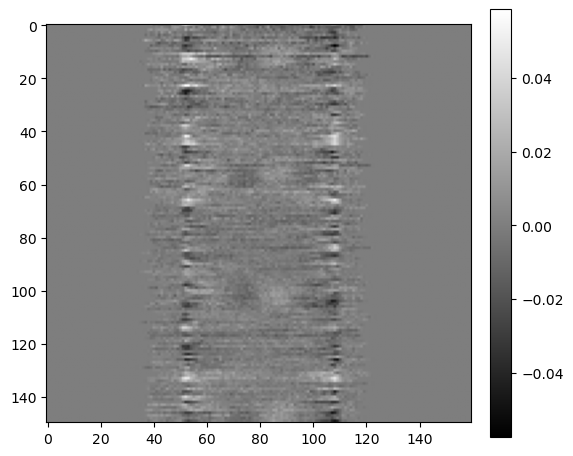

In [7]:
# data = F1(w)
# mshow(data[w.shape[0]//2].get())
# data = F1(w)

mshow(data[w.shape[0]//2].get())

### Reconstruction $\|R(w)-d\|_2^2+\lambda\|w_x\cos(\phi)+w_y\sin(\phi)\|_2^2$

0 err=179.00172424316406


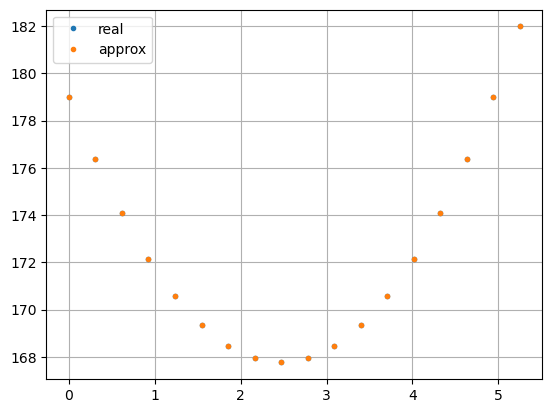

8 err=135.9886016845703
16 err=133.50856018066406
24 err=132.9925537109375
32 err=132.69822692871094


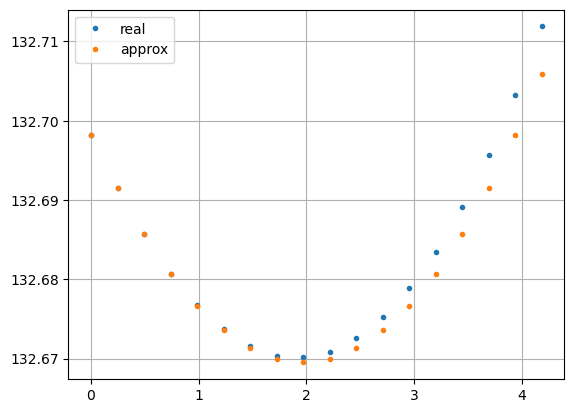

40 err=132.5189971923828
48 err=132.39328002929688
56 err=132.2928466796875
64 err=132.22308349609375


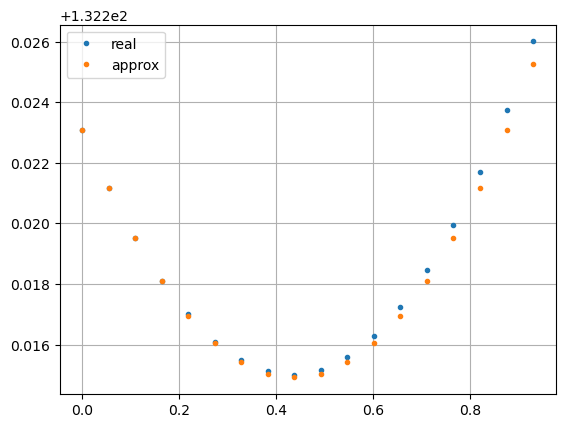

72 err=132.1726837158203
80 err=132.1330108642578
88 err=132.1029052734375
96 err=132.0777587890625


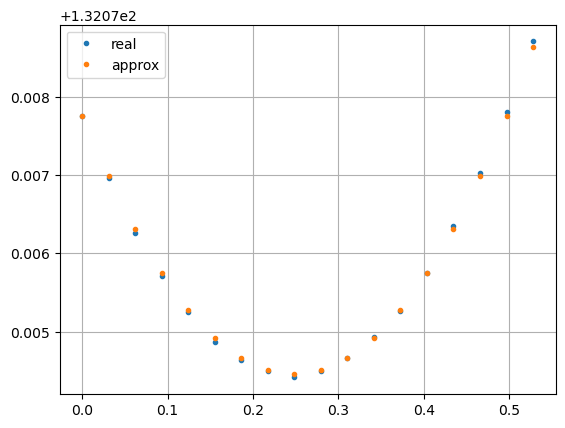

104 err=132.05348205566406
112 err=132.03086853027344
120 err=132.00726318359375
128 err=131.98333740234375


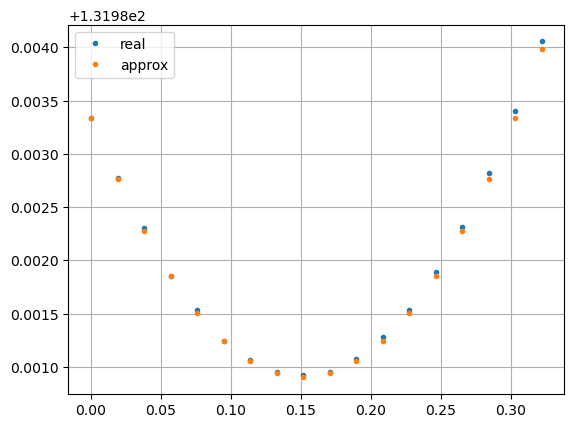

vars['phi']=array(-0.98017937, dtype=float32)


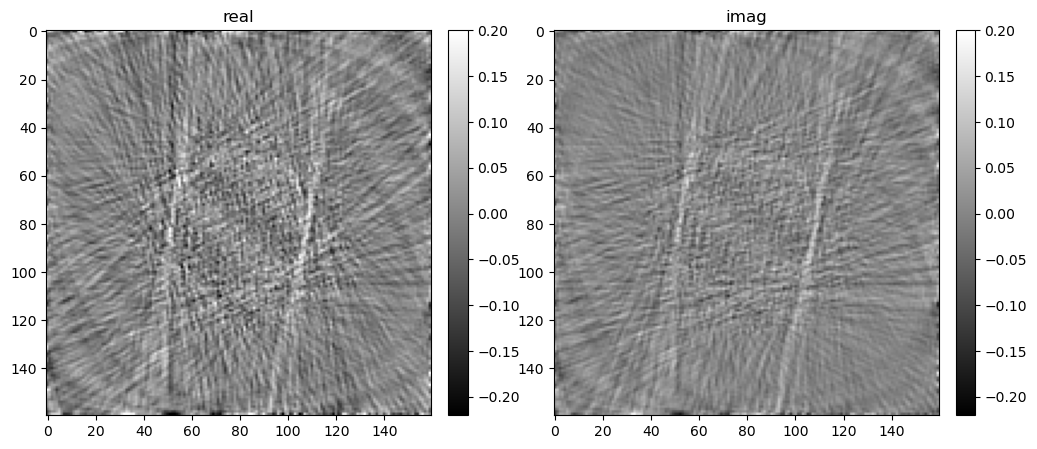

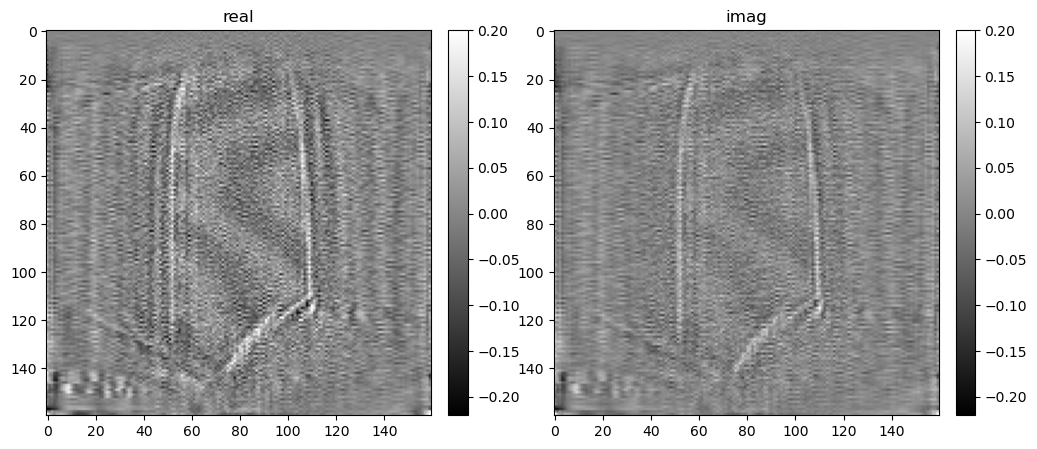

In [ ]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.float32(0)
lam = 0.0001
niter = 257
vars,err2 = BH(vars,data,niter,lam)

print(f'{vars['phi']=}')
mshow_complex(vars['w'][w.shape[0]//2,:,:,0]+1j*vars['w'][w.shape[0]//2,:,:,1],vmin=0.2,vmax=-0.2)
mshow_complex(vars['w'][:,w.shape[1]//2,:,0]+1j*vars['w'][:,w.shape[1]//2,:,1],vmin=0.2,vmax=-0.2)


0 err=179.00172424316406


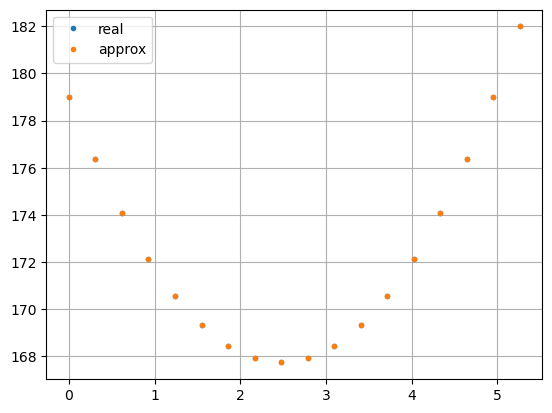

8 err=134.92982482910156
16 err=131.9663543701172
24 err=131.5015869140625
32 err=131.34320068359375


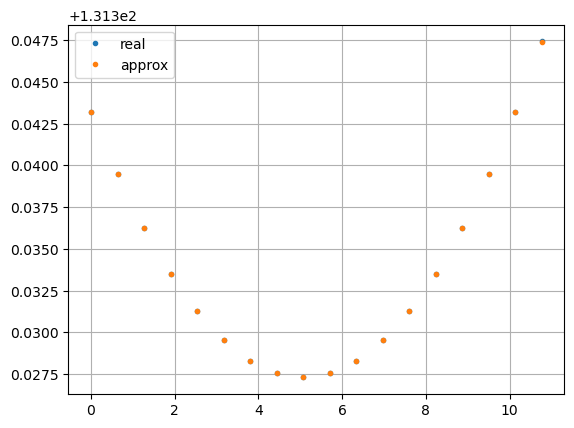

40 err=131.20455932617188
48 err=131.1284942626953
56 err=131.04701232910156
vars['phi']=array(-1.6882563, dtype=float32)


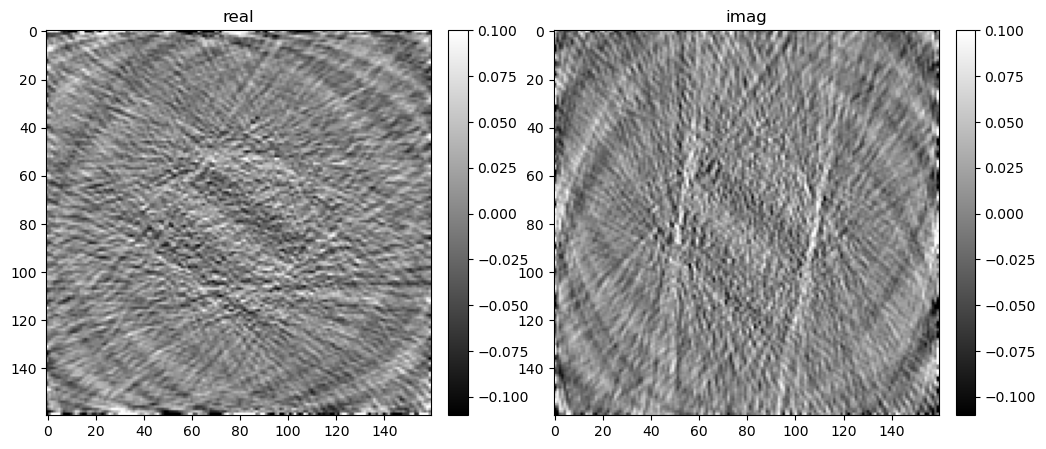

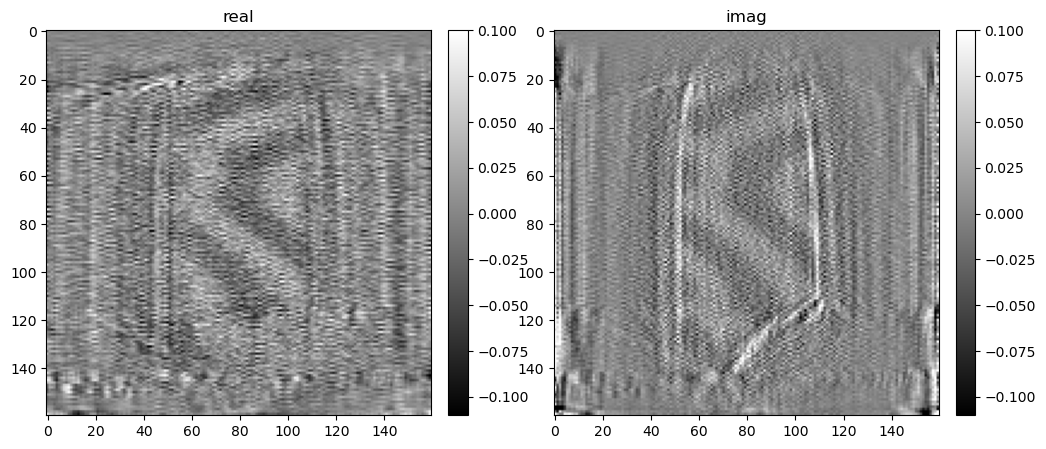

In [9]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.float32(0)
lam = 0.00001
niter = 64
vars,err2 = BH(vars,data,niter,lam)

print(f'{vars['phi']=}')
mshow_complex(vars['w'][w.shape[0]//2,:,:,0]+1j*vars['w'][w.shape[0]//2,:,:,1],vmin=0.1,vmax=-0.1)
mshow_complex(vars['w'][:,w.shape[1]//2,:,0]+1j*vars['w'][:,w.shape[1]//2,:,1],vmin=0.1,vmax=-0.1)


0 err=179.00172424316406


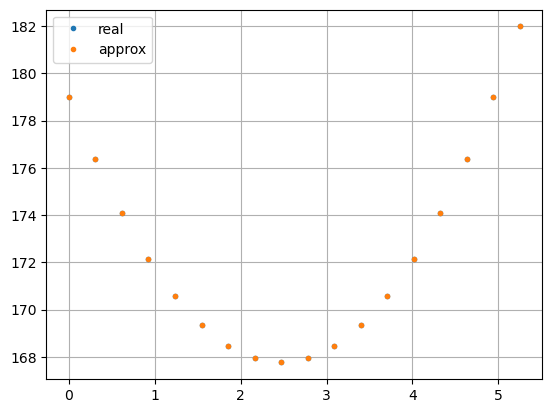

8 err=135.9886016845703
16 err=133.50857543945312
24 err=132.9925537109375
32 err=132.69822692871094


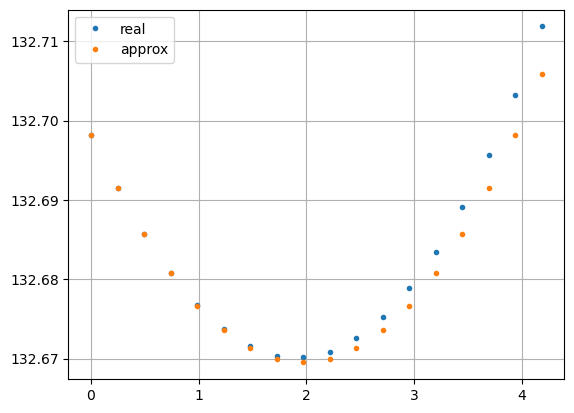

40 err=132.5189971923828
48 err=132.39328002929688
56 err=132.2928466796875
vars['phi']=array(-1.0098515, dtype=float32)


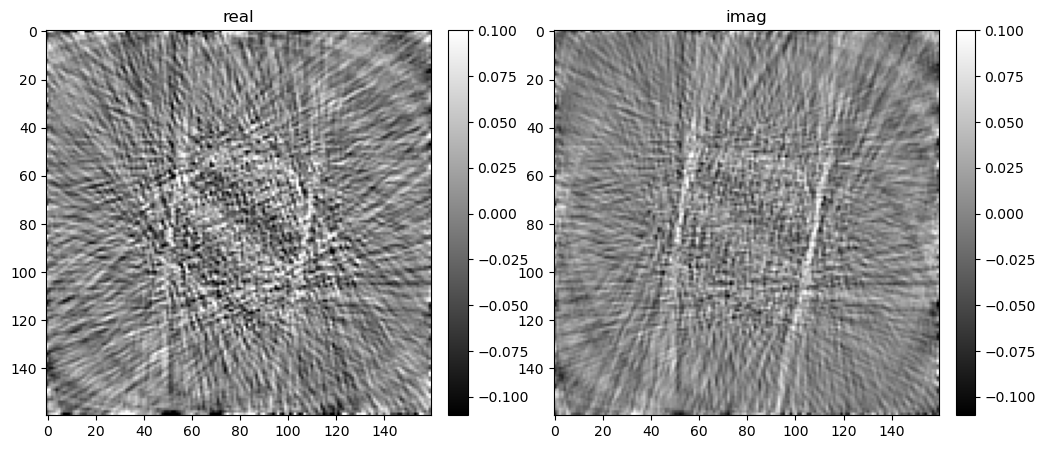

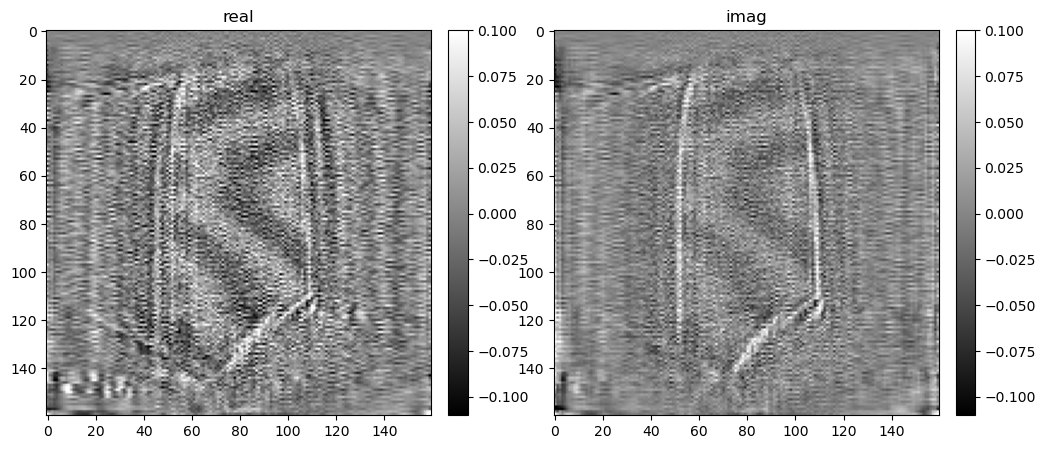

In [10]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.float32(0)
lam = 0.001
niter = 64
vars,err2 = BH(vars,data,niter,lam)

print(f'{vars['phi']=}')
mshow_complex(vars['w'][w.shape[0]//2,:,:,0]+1j*vars['w'][w.shape[0]//2,:,:,1],vmin=0.1,vmax=-0.1)
mshow_complex(vars['w'][:,w.shape[1]//2,:,0]+1j*vars['w'][:,w.shape[1]//2,:,1],vmin=0.1,vmax=-0.1)


### Reconstruction $\|R(w)-d\|_2^2

0 err=179.00172424316406


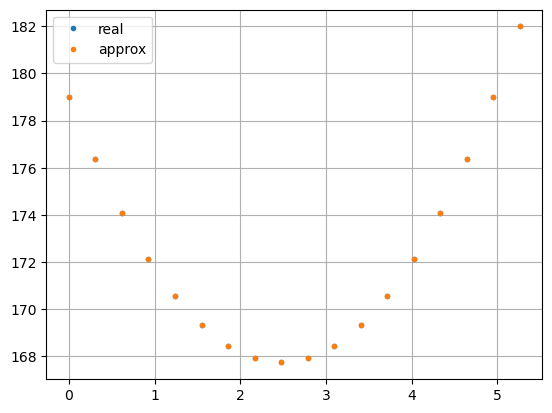

8 err=134.91709899902344
16 err=131.9479522705078
24 err=131.48231506347656
32 err=131.32174682617188


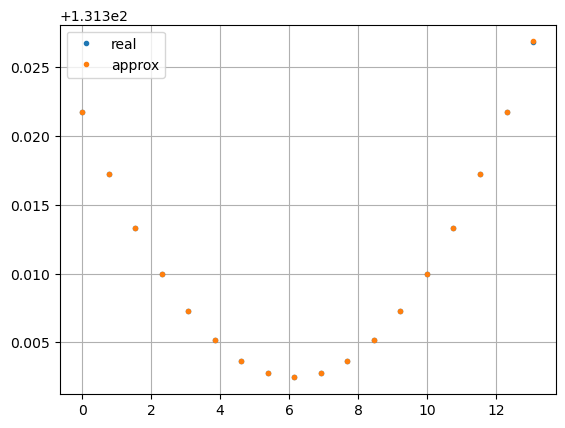

40 err=131.1708221435547
48 err=131.09703063964844
56 err=131.01690673828125
vars['phi']=array(0., dtype=float32)


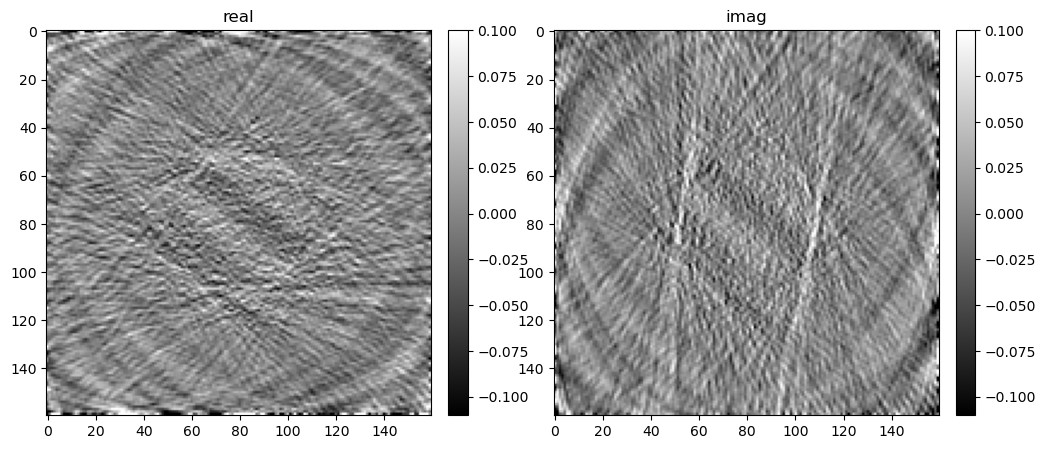

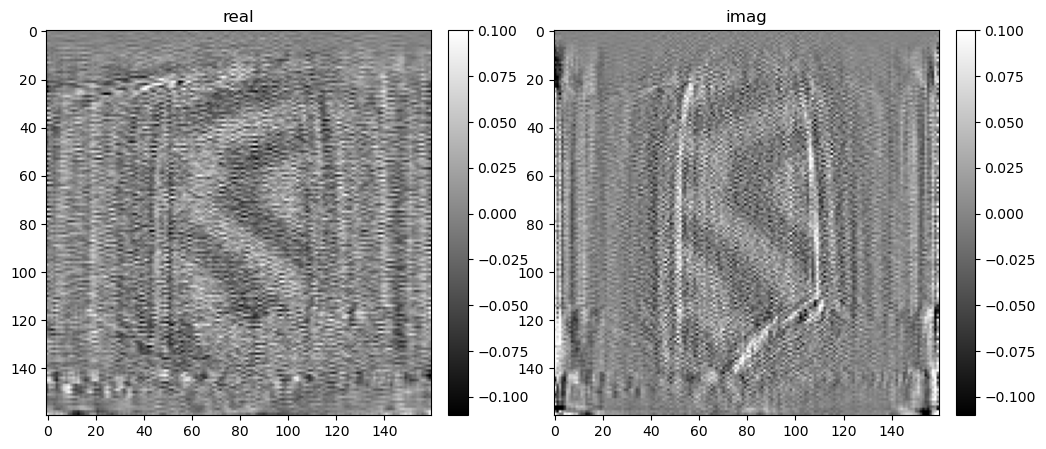

In [11]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.float32(0)
lam = 0.0
niter = 64
vars,err2 = BH(vars,data,niter,lam)

print(f'{vars['phi']=}')
mshow_complex(vars['w'][w.shape[0]//2,:,:,0]+1j*vars['w'][w.shape[0]//2,:,:,1],vmin=0.1,vmax=-0.1)
mshow_complex(vars['w'][:,w.shape[1]//2,:,0]+1j*vars['w'][:,w.shape[1]//2,:,1],vmin=0.1,vmax=-0.1)
